In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import scipy.stats as stats
import scipy.ndimage

%config InlineBackend.figure_format = 'retina'

In [3]:
raw = pd.read_csv('flights-10m.csv')
# raw = pd.read_csv('flights-10m.csv', nrows=10000)

In [4]:
ranges = {
    "AirTime": [0, 300],
    "ArrDelay": [-20, 50],
    "DepTime": [0, 2400],
    "ArrTime": [0, 2400],
    "DepDelay": [-10, 50],
    "Distance": [200, 2000]
}

dims = [x for x,_ in ranges.items()]

pixels = 500
bins = 25

def run(active, passive):
    active_range = ranges[active]
    passive_range = ranges[passive]

    df = raw[
        (active_range[0] <= raw[active]) & (raw[active] < active_range[1]) &
        (passive_range[0] <= raw[passive]) & (raw[passive] < passive_range[1])]

    bins_active = np.linspace(active_range[0], active_range[1], pixels + 1)
    bins_passive = np.linspace(passive_range[0], passive_range[1], bins + 1)

    hist, xedges, yedges = np.histogram2d(df[active], df[passive], bins=(bins_active, bins_passive))

    unfiltered, edges = np.histogram(df[passive], bins=bins_passive)

    pdf = np.vstack([np.zeros(bins), hist])
    cdf = np.cumsum(pdf, axis=0)

    idx = list(range(0,pixels+1, int(pixels/bins)))
    low_res = cdf[idx, :]

    p = np.arange(0, pixels+1, pixels/bins);
    i = interpolate.interp1d(p, low_res, kind="linear", axis=0)

    to_interpolate = np.arange(0, pixels+1)
    interpolated_cdf = i(to_interpolate)

    data = []

    min_brush = int(pixels / bins)

    for size in range(min_brush, pixels, 20):
        for start in range(pixels - size):
            end = start + size

            hist_a = interpolated_cdf[end] - interpolated_cdf[start]
            hist_b = cdf[end] - cdf[start]

            # scaling factor to scale to unfiltered data
            factor = hist_b.max() / unfiltered.max()
    #         factor = 1

            if sum(hist_a) == 0 and sum(hist_b) == 0:
                w = 0
            if sum(hist_a) == 0 or sum(hist_b) == 0:
                print(f"Skipped comparison because one histogram is zero at {start} with size {size}")
                raise RuntimeError("foo")
                continue
            else:
                w = stats.wasserstein_distance(np.arange(bins)/(bins-1), np.arange(bins)/(bins-1), hist_a, hist_b)
                
            d = w * factor

            sumdiff = hist_a.sum() - hist_b.sum()

            data.append([start, size, d, w, hist_a.sum(), hist_b.sum(), sumdiff])

    distances = pd.DataFrame(data, columns=["start", "size", "distance", "wasserstein", "sum_a", "sum_b", "sumdiff"])

    worst = distances.loc[distances.distance.idxmax()]
    
    return worst.wasserstein

data = []
    
for active in dims:
    for passive in dims:
        if active != passive:
            print("Active:", active, "Passive:", passive)
            d = run(active, passive)
            print("Worst:", d)
            data.append([active, passive, d])

Active: AirTime Passive: ArrDelay
Worst: 0.004680009560092084
Active: AirTime Passive: DepTime
Worst: 0.0006146705493543126
Active: AirTime Passive: ArrTime
Worst: 0.000262472059337299
Active: AirTime Passive: DepDelay
Worst: 0.004826952282548133
Active: AirTime Passive: Distance
Worst: 0.00705797000236236
Active: ArrDelay Passive: AirTime
Worst: 0.002775965831795485
Active: ArrDelay Passive: DepTime
Worst: 0.0016390559739935069
Active: ArrDelay Passive: ArrTime
Worst: 0.0019103477854176872
Active: ArrDelay Passive: DepDelay
Worst: 0.006962502613611606
Active: ArrDelay Passive: Distance
Worst: 0.0019493150194632258
Active: DepTime Passive: AirTime
Worst: 0.04171962905690825
Active: DepTime Passive: ArrDelay
Worst: 0.0020521434262449853
Active: DepTime Passive: ArrTime
Worst: 0.1427573093400819
Active: DepTime Passive: DepDelay
Worst: 0.002702325679331357
Active: DepTime Passive: Distance
Worst: 0.0018270042628807921
Active: ArrTime Passive: AirTime
Worst: 0.08051374310250276
Active: Ar

In [5]:
df = pd.DataFrame(data, columns=["active", "passive", "dist"])
df['key'] = df.active + df.passive

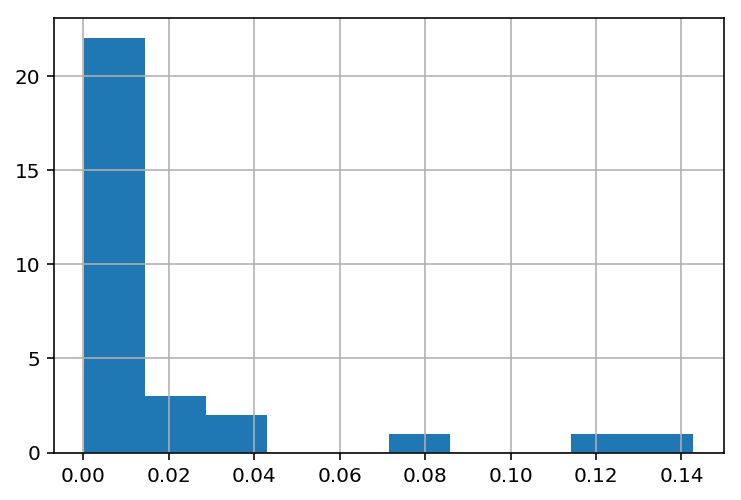

In [6]:
df.dist.hist()

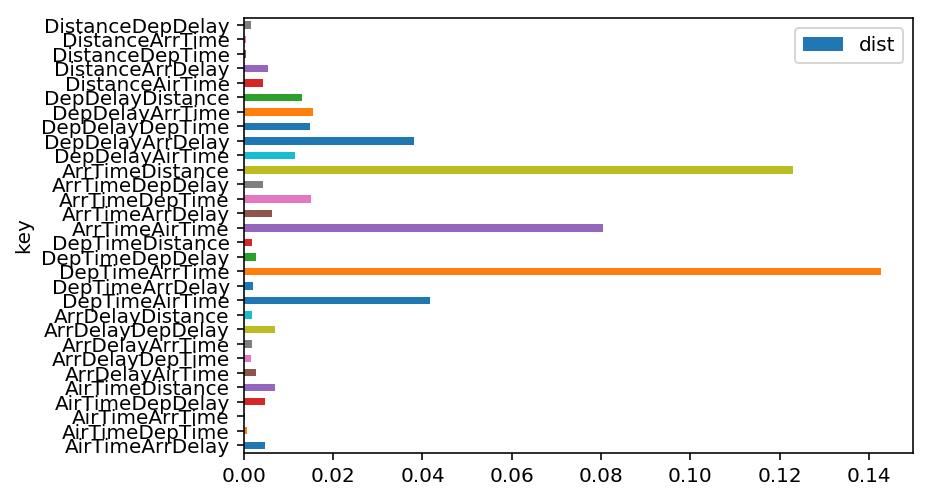

In [7]:
df.plot.barh(x='key', y='dist', rot=0)